In [2]:
import pandas as pd
import cupy as cp  # Optional: for GPU acceleration
import os
import numpy as np
import tensorflow as tf
from cuml.preprocessing import MinMaxScaler
from cuml.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- CONFIG ---
CLEANED_PATH = "/home/kdn-admin/Documents/Intern-Exploratory-Projects/Team/SHUBHAM-GAYATRI/AI-POWERED-AUTONOMOUS-FINANCIAL-REPORTING/backend/data_processing/financial_reports/cleaned"
SEQ_LENGTH = 5
TARGET_COL = "totalrevenue"


In [3]:
companies = list(set([f.split("_")[0] for f in os.listdir(CLEANED_PATH)]))
company_data = {}

for company in companies:
    try:
        bs = pd.read_csv(f"{CLEANED_PATH}/{company}_balance_sheet_cleaned.csv")
        is_ = pd.read_csv(f"{CLEANED_PATH}/{company}_income_statement_cleaned.csv")
        cf = pd.read_csv(f"{CLEANED_PATH}/{company}_cash_flow_cleaned.csv")

        for df in [bs, is_, cf]:
            df["year"] = pd.to_datetime(df["year"], errors='coerce').dt.year

        df = bs.merge(is_, on=["year", "symbol", "reportedcurrency"], how="inner")
        df = df.merge(cf, on=["year", "symbol", "reportedcurrency"], how="inner")
        df = df[df["year"].isin(list(range(2009, 2025)))]
        company_data[company] = df.reset_index(drop=True)
        print(f"✅ {company} loaded")
    except Exception as e:
        print(f"⚠️ {company} failed: {e}")

✅ GOOGL loaded
✅ AAPL loaded
✅ TSLA loaded
✅ META loaded
✅ JPM loaded
✅ V loaded
✅ IBM loaded
✅ NVDA loaded
✅ AMZN loaded
✅ MSFT loaded


In [4]:
scaler = MinMaxScaler()
X_all, y_all = [], []

def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

for company, df in company_data.items():
    try:
        df = df.dropna()
        df["year"] = df["year"].astype("int32")

        numeric_cols = df.select_dtypes(include=["int32", "float64", "float32", "int64"]).columns
        numeric_cols = [c for c in numeric_cols if c != "year"]

        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

        if TARGET_COL not in df.columns:
            continue

        target_data = df[TARGET_COL].to_numpy().reshape(-1, 1)
        X, y = create_sequences(target_data, SEQ_LENGTH)

        X_all.append(X)
        y_all.append(y)
        print(f"✅ Sequences created for {company}")
    except Exception as e:
        print(f"⚠️ {company} failed during sequence processing: {e}")


✅ Sequences created for GOOGL
✅ Sequences created for AAPL
✅ Sequences created for TSLA
✅ Sequences created for META
✅ Sequences created for JPM
✅ Sequences created for V
✅ Sequences created for IBM
✅ Sequences created for NVDA
✅ Sequences created for AMZN
✅ Sequences created for MSFT


In [5]:
X_all = np.concatenate(X_all, axis=0)
y_all = np.concatenate(y_all, axis=0)

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=False)

print(f"✅ Final Dataset: X_train: {X_train.shape}, X_test: {X_test.shape}")

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    tf.keras.layers.LSTM(50, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test))


✅ Final Dataset: X_train: (76, 5, 1), X_test: (18, 5, 1)


W0000 00:00:1744175280.943131  614086 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/kdn-admin/Documents/Intern-Exploratory-Projects/Team/SHUBHAM-GAYATRI/AI-POWERED-AUTONOMOUS-FINANCIAL-REPORTING/env-financial-reporting/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.1601 - val_loss: 0.0142
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0803 - val_loss: 0.0065
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0730 - val_loss: 0.0049
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0441 - val_loss: 0.0209
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0443 - val_loss: 0.0189
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0427 - val_loss: 0.0120
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0445 - val_loss: 0.0103
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0273 - val_loss: 0.0111
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0285 - val_loss: 0.0116
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0458 - val_loss: 0.0090
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0377 - val_loss: 0.0055
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.031

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
📉 MSE: 0.00
📊 MAE: 0.03
📈 R² Score: 0.8104


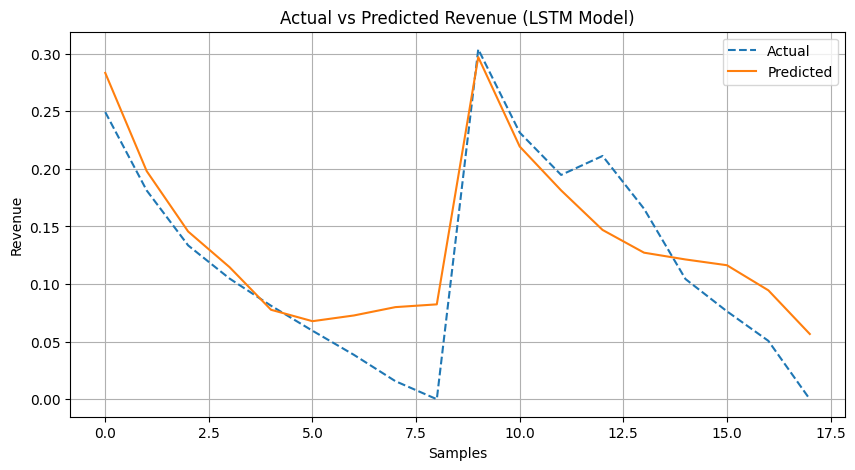

In [6]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📉 MSE: {mse:.2f}")
print(f"📊 MAE: {mae:.2f}")
print(f"📈 R² Score: {r2:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual", linestyle='--')
plt.plot(y_pred, label="Predicted", linestyle='-')
plt.title("Actual vs Predicted Revenue (LSTM Model)")
plt.xlabel("Samples")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.show()


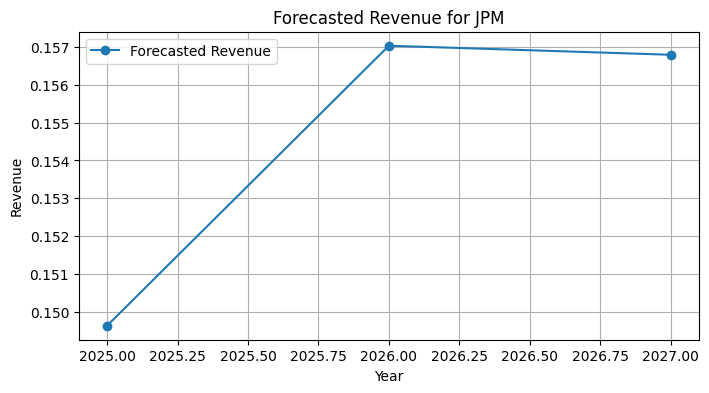

In [16]:
# Choose a specific company for forecasting
forecast_company = list(company_data.keys())[4]
df = company_data[forecast_company].dropna()

numeric_cols = df.select_dtypes(include=["int32", "float64", "float32", "int64"]).columns
numeric_cols = [c for c in numeric_cols if c != "year"]
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Get last sequence for forecasting
target_data = df[TARGET_COL].to_numpy().reshape(-1, 1)

if len(target_data) < SEQ_LENGTH:
    raise ValueError(f"Not enough data points ({len(target_data)}) to create a sequence of length  {SEQ_LENGTH}")

last_seq = target_data[-SEQ_LENGTH:]
current_seq = last_seq.reshape(1, SEQ_LENGTH, 1)

# Forecast future values
n_future = 3  # Predict 3 future years
future_preds = []
# current_seq = last_seq.copy()

for _ in range(n_future):
    pred = model.predict(current_seq, verbose=0)[0][0]
    future_preds.append(pred)

    new_input = np.concatenate([current_seq[:,1:,:], np.array([[[pred]]])], axis=1)
    current_seq = new_input
    # current_seq = np.append(current_seq[:, 1:, :], [[[pred]]], axis=1)

# Inverse scale if needed
# future_preds_rescaled = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# Plot
future_years = list(range(2025, 2025 + n_future))
plt.figure(figsize=(8, 4))
plt.plot(future_years, future_preds, marker='o', label="Forecasted Revenue")
plt.title(f"Forecasted Revenue for {forecast_company}")
plt.xlabel("Year")
plt.ylabel("Revenue")
plt.grid(True)
plt.legend()
plt.show()


In [17]:
from sklearn.preprocessing import MinMaxScaler

def forecast_all_companies(company_data, model, target_col="totalrevenue", n_future=3):
    results = []
    for company, df in company_data.items():
        try:
            df = df.dropna()
            if target_col not in df.columns:
                continue
            # Scale only totalrevenue separately            
            revenue_scaler = MinMaxScaler()
            target_data = df[[target_col]].to_numpy()
            scaled_revenue = revenue_scaler.fit_transform(target_data)
            if len(scaled_revenue) < SEQ_LENGTH: 
                print(f" {company} skipped (not enough data)")
                continue
            # Create initial sequence            
            current_seq = scaled_revenue[-SEQ_LENGTH:].reshape(1, SEQ_LENGTH, 1)
            future_preds = []
            for _ in range(n_future):   
                pred_scaled = model.predict(current_seq, verbose=0)[0][0]
                future_preds.append(pred_scaled)
            new_input = np.concatenate([current_seq[:, 1:, :], np.array([[[pred_scaled]]])], axis=1)
            current_seq = new_input
            # Inverse transform to get actual revenue            
            future_actual = revenue_scaler.inverse_transform(np.array(future_preds).reshape(-1, 1)).flatten()
            years = list(range(2025, 2025 + n_future))
            for year, revenue in zip(years, future_actual):
                results.append({
                    "company": company,
                    "year": year, 
                    "forecasted_revenue": revenue
                })
            print(f" Forecasted for {company}")
        except Exception as e:
            print(f" {company} failed: {e}")
            
    return pd.DataFrame(results)
# Run the function
forecast_df = forecast_all_companies(company_data, model, TARGET_COL, n_future=3)
# Show a sample
forecast_df.head()

 Forecasted for GOOGL
 Forecasted for AAPL
 Forecasted for TSLA
 Forecasted for META
 Forecasted for JPM
 Forecasted for V
 Forecasted for IBM
 Forecasted for NVDA
 Forecasted for AMZN
 Forecasted for MSFT


,company,year,forecasted_revenue
0,GOOGL,2025,8.306079e+10
1,GOOGL,2026,8.306079e+10
2,GOOGL,2027,8.306079e+10
3,AAPL,2025,6.053815e+10
4,AAPL,2026,6.053815e+10


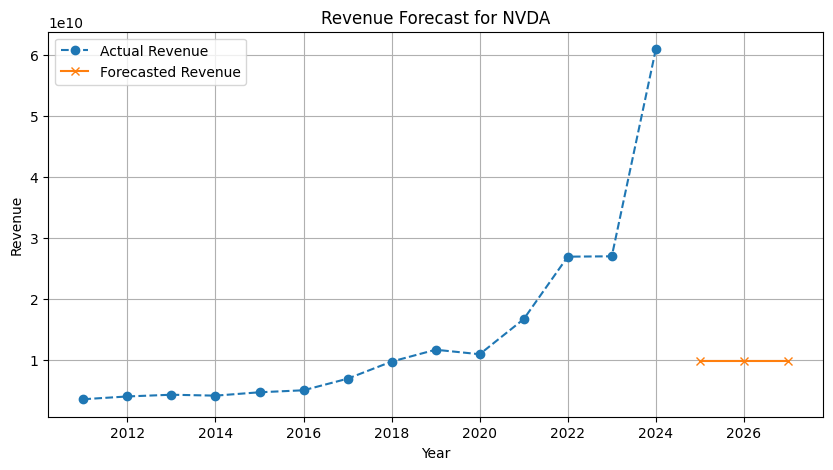

In [27]:
def plot_forecast(company_name, forecast_df, company_data, target_col="totalrevenue"):
    df = company_data[company_name].dropna()
    actual_years = df["year"].tolist()
    actual_values = df[target_col].tolist()
    forecast_values = forecast_df[forecast_df["company"] == company_name]
    forecast_years = forecast_values["year"].tolist()
    forecasted_values = forecast_values["forecasted_revenue"].tolist()
    plt.figure(figsize=(10, 5))
    plt.plot(actual_years, actual_values, label="Actual Revenue", linestyle='--', marker='o')
    plt.plot(forecast_years, forecasted_values, label="Forecasted Revenue", linestyle='-', marker='x')
    plt.title(f"Revenue Forecast for {company_name}")
    plt.xlabel("Year")
    plt.ylabel("Revenue")
    plt.grid(True)
    plt.legend()
    plt.show()
# Example usage
plot_forecast("NVDA", forecast_df, company_data, TARGET_COL)

In [28]:
# Redefine sequence generator for multivariate X and univariate y
def create_multivariate_sequences(X_data, y_data, seq_len):
    X, y = [], []
    for i in range(len(X_data) - seq_len):
        X.append(X_data[i:i + seq_len])
        y.append(y_data[i + seq_len])
    return np.array(X), np.array(y)

# Reset containers
X_all, y_all = [], []

for company, df in company_data.items():
    try:
        df = df.dropna()
        df["year"] = df["year"].astype("int32")

        # Select numeric features (excluding year)
        numeric_cols = df.select_dtypes(include=["int32", "float64", "float32", "int64"]).columns
        numeric_cols = [c for c in numeric_cols if c != "year"]

        if TARGET_COL not in numeric_cols:
            continue

        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

        X_data = df[numeric_cols].to_numpy()
        y_data = df[[TARGET_COL]].to_numpy()

        X, y = create_multivariate_sequences(X_data, y_data, SEQ_LENGTH)
        X_all.append(X)
        y_all.append(y)

        print(f"✅ Multivariate sequences created for {company}")
    except Exception as e:
        print(f"⚠️ {company} failed: {e}")

✅ Multivariate sequences created for GOOGL
✅ Multivariate sequences created for AAPL
✅ Multivariate sequences created for TSLA
✅ Multivariate sequences created for META
✅ Multivariate sequences created for JPM
✅ Multivariate sequences created for V
✅ Multivariate sequences created for IBM
✅ Multivariate sequences created for NVDA
✅ Multivariate sequences created for AMZN
✅ Multivariate sequences created for MSFT


In [29]:
X_all = np.concatenate(X_all, axis=0)
y_all = np.concatenate(y_all, axis=0)

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=False)
print(f"✅ Multivariate Dataset: X_train: {X_train.shape}, X_test: {X_test.shape}")

✅ Multivariate Dataset: X_train: (76, 5, 88), X_test: (18, 5, 88)


In [34]:
n_features = X_train.shape[2]
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation='relu', return_sequences=True, input_shape=(SEQ_LENGTH, n_features)),
    tf.keras.layers.LSTM(64, activation='relu'),
    tf.keras.layers.Dense(1) # Still predicting totalrevenue
])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test))

Epoch 1/50


/home/kdn-admin/Documents/Intern-Exploratory-Projects/Team/SHUBHAM-GAYATRI/AI-POWERED-AUTONOMOUS-FINANCIAL-REPORTING/env-financial-reporting/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.1217 - val_loss: 0.0231
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0271 - val_loss: 0.0084
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0092 - val_loss: 0.0060
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0060 - val_loss: 0.0066
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0069 - val_loss: 0.0106
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0053 - val_loss: 0.0060
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0062 - val_loss: 0.0028
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038 - val_loss: 0.0105
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045 - val_loss: 0.0021
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - val_loss: 0.0025
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038 - val_loss

In [31]:
def multivariate_forecast(company_data, model, target_col, seq_length=5, n_future=3):
    results = []

    for company, df in company_data.items():
        try:
            df = df.dropna()
            if target_col not in df.columns:
                continue

            numeric_cols = df.select_dtypes(include=["int32", "float64", "float32", "int64"]).columns
            numeric_cols = [c for c in numeric_cols if c != "year"]

            # Use same scaler for all inputs
            input_scaler = MinMaxScaler()
            target_scaler = MinMaxScaler()

            df[numeric_cols] = input_scaler.fit_transform(df[numeric_cols])
            target_scaled = target_scaler.fit_transform(df[[target_col]])

            if len(df) < seq_length:
                continue

            last_seq = df[numeric_cols].values[-seq_length:].reshape(1, seq_length, -1)
            future_preds = []

            for _ in range(n_future):
                pred_scaled = model.predict(last_seq, verbose=0)[0][0]
                future_preds.append(pred_scaled)

                # Append the predicted revenue back to the sequence (fake new row)
                new_row = last_seq[0, -1].copy()
                target_index = numeric_cols.index(target_col)
                new_row[target_index] = pred_scaled

                last_seq = np.append(last_seq[:, 1:, :], [[new_row]], axis=1)

            predicted = target_scaler.inverse_transform(np.array(future_preds).reshape(-1, 1)).flatten()
            years = list(range(2025, 2025 + n_future))

            for year, value in zip(years, predicted):
                results.append({
                    "company": company,
                    "year": year,
                    "forecasted_revenue": value
                })

            print(f"✅ Forecasted multivariate for {company}")

        except Exception as e:
            print(f"❌ {company} error: {e}")

    return pd.DataFrame(results)

# Run it
forecast_df = multivariate_forecast(company_data, model, TARGET_COL)
forecast_df.head()

✅ Forecasted multivariate for GOOGL
✅ Forecasted multivariate for AAPL
✅ Forecasted multivariate for TSLA
✅ Forecasted multivariate for META
✅ Forecasted multivariate for JPM
✅ Forecasted multivariate for V
✅ Forecasted multivariate for IBM
✅ Forecasted multivariate for NVDA
✅ Forecasted multivariate for AMZN
✅ Forecasted multivariate for MSFT


,company,year,forecasted_revenue
0,GOOGL,2025,0.011148
1,GOOGL,2026,0.001958
2,GOOGL,2027,-0.001909
3,AAPL,2025,-0.051077
4,AAPL,2026,-0.081479


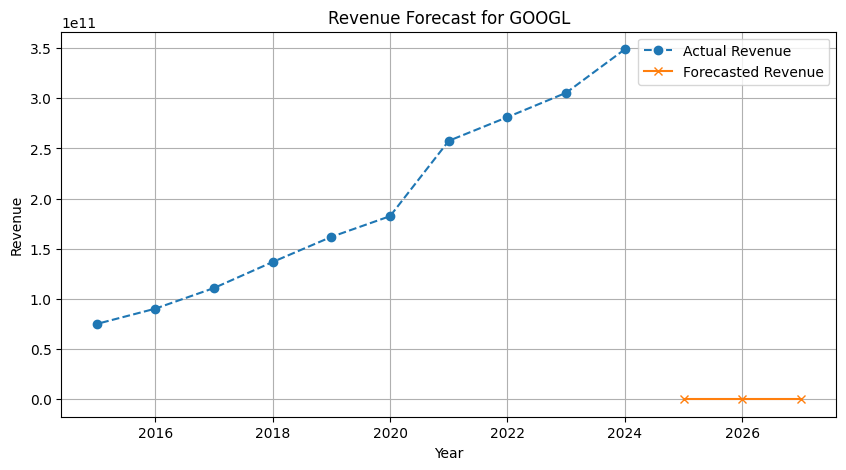

In [ ]:
plot_forecast("GOOGL", forecast_df, company_data, TARGET_COL)

In [36]:
financial_targets = ["totalrevenue","netincome","totalassets","totaldebt","grossprofit","totalcurrentassets"]

In [37]:
all_forecasts = []

for target in financial_targets:
    print(f"\n=== Forecasting: {target.upper()} ===")
    
    # Recreate sequences (X, y) for this target
    X_all, y_all = [], []
    for company, df in company_data.items():
        try:
            df = df.dropna()
            if target not in df.columns:
                continue

            df["year"] = df["year"].astype("int32")
            numeric_cols = df.select_dtypes(include=["int32", "float64", "float32", "int64"]).columns
            numeric_cols = [c for c in numeric_cols if c != "year"]

            df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
            X_data = df[numeric_cols].to_numpy()
            y_data = df[[target]].to_numpy()

            X, y = create_multivariate_sequences(X_data, y_data, SEQ_LENGTH)
            X_all.append(X)
            y_all.append(y)
        except Exception as e:
            print(f"❌ Sequence error for {company}: {e}")

    if not X_all:
        continue

    X_all = np.concatenate(X_all, axis=0)
    y_all = np.concatenate(y_all, axis=0)
    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=False)

    # Build model
    n_features = X_train.shape[2]
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, activation='relu', return_sequences=True, input_shape=(SEQ_LENGTH, n_features)),
        tf.keras.layers.LSTM(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=30, batch_size=8, verbose=0)

    # Forecast for this target
    df_target_forecast = multivariate_forecast(company_data, model, target)
    df_target_forecast["target"] = target
    all_forecasts.append(df_target_forecast)


=== Forecasting: TOTALREVENUE ===


/home/kdn-admin/Documents/Intern-Exploratory-Projects/Team/SHUBHAM-GAYATRI/AI-POWERED-AUTONOMOUS-FINANCIAL-REPORTING/env-financial-reporting/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Forecasted multivariate for GOOGL
✅ Forecasted multivariate for AAPL
✅ Forecasted multivariate for TSLA
✅ Forecasted multivariate for META
✅ Forecasted multivariate for JPM
✅ Forecasted multivariate for V
✅ Forecasted multivariate for IBM
✅ Forecasted multivariate for NVDA
✅ Forecasted multivariate for AMZN
✅ Forecasted multivariate for MSFT

=== Forecasting: NETINCOME ===

=== Forecasting: TOTALASSETS ===


/home/kdn-admin/Documents/Intern-Exploratory-Projects/Team/SHUBHAM-GAYATRI/AI-POWERED-AUTONOMOUS-FINANCIAL-REPORTING/env-financial-reporting/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Forecasted multivariate for GOOGL
✅ Forecasted multivariate for AAPL
✅ Forecasted multivariate for TSLA
✅ Forecasted multivariate for META
✅ Forecasted multivariate for JPM
✅ Forecasted multivariate for V
✅ Forecasted multivariate for IBM
✅ Forecasted multivariate for NVDA
✅ Forecasted multivariate for AMZN
✅ Forecasted multivariate for MSFT

=== Forecasting: TOTALDEBT ===

=== Forecasting: GROSSPROFIT ===


/home/kdn-admin/Documents/Intern-Exploratory-Projects/Team/SHUBHAM-GAYATRI/AI-POWERED-AUTONOMOUS-FINANCIAL-REPORTING/env-financial-reporting/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Forecasted multivariate for GOOGL
✅ Forecasted multivariate for AAPL
✅ Forecasted multivariate for TSLA
✅ Forecasted multivariate for META
✅ Forecasted multivariate for JPM
✅ Forecasted multivariate for V
✅ Forecasted multivariate for IBM
✅ Forecasted multivariate for NVDA
✅ Forecasted multivariate for AMZN
✅ Forecasted multivariate for MSFT

=== Forecasting: TOTALCURRENTASSETS ===


/home/kdn-admin/Documents/Intern-Exploratory-Projects/Team/SHUBHAM-GAYATRI/AI-POWERED-AUTONOMOUS-FINANCIAL-REPORTING/env-financial-reporting/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Forecasted multivariate for GOOGL
✅ Forecasted multivariate for AAPL
✅ Forecasted multivariate for TSLA
✅ Forecasted multivariate for META
✅ Forecasted multivariate for JPM
✅ Forecasted multivariate for V
✅ Forecasted multivariate for IBM
✅ Forecasted multivariate for NVDA
✅ Forecasted multivariate for AMZN
✅ Forecasted multivariate for MSFT


In [38]:
final_forecast_df = pd.concat(all_forecasts).reset_index(drop=True)
final_forecast_df.to_csv("multi_target_forecast.csv", index=False)
print("✅ Saved all target forecasts to multi_target_forecast.csv")

✅ Saved all target forecasts to multi_target_forecast.csv


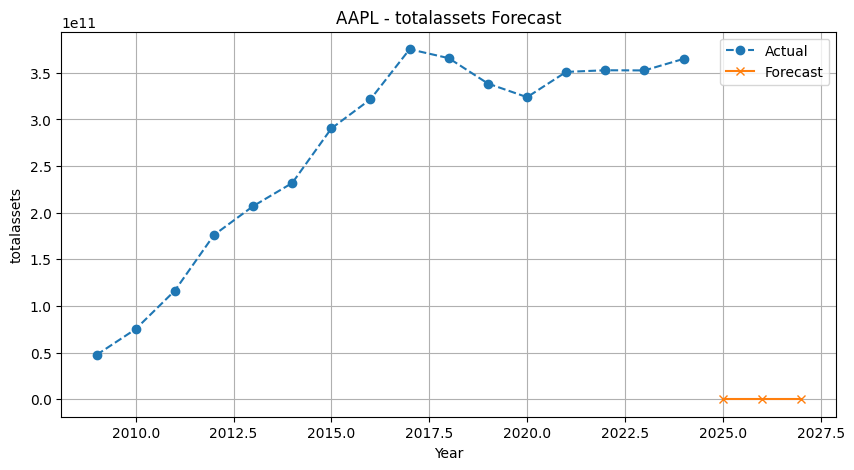

In [41]:
def plot_target_forecast(company, target, df, company_data):
    subset = df[(df["company"] == company) & (df["target"] == target)]
    actual_df = company_data[company]
    actual = actual_df[["year", target]].dropna().copy()
    actual = actual[actual["year"] >= 2009]
    actual = actual.groupby("year").mean()
    # Plot    
    plt.figure(figsize=(10, 5)) 
    plt.plot(actual.index, actual[target], label="Actual", linestyle='--', marker='o')
    plt.plot(subset["year"], subset["forecasted_revenue"], label="Forecast", linestyle='-', marker='x')
    plt.title(f"{company} - {target} Forecast")
    plt.xlabel("Year")
    plt.ylabel(target)
    plt.grid(True)
    plt.legend()
    plt.show()
# Example:
plot_target_forecast("AAPL", "totalassets", final_forecast_df, company_data)